## Linear classifiers

In [1]:
import time
import math
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, log_loss
from sklearn.cross_validation import train_test_split
from linear_svm import svm_loss_naive, svm_loss_vectorized
from gradient_check import grad_check_sparse
from linear_classifier import LinearSVM, Softmax
from softmax import softmax_loss_naive, softmax_loss_vectorized


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [38]:
# utility function
def output_to_csv(result_matrix, indices, filename):
    df = pd.DataFrame(result_matrix)
    df.index = indices
    df.index.name = 'ID'
    df.columns = ['class_0', 'class_1', 'class_2', 'class_3']
    df.to_csv(filename)

-------
#### Знакомство с данными

In [3]:
data = pd.read_csv('kaggle_data/train.csv', index_col=0, na_values='NaN')
test_data = pd.read_csv('kaggle_data/test.csv', index_col=0, na_values='NaN')
print(data.shape)
print(data.head())
print(test_data.head())

(352278, 2)
                                                  summary  score
id                                                              
230872                                  Babies love these      3
344823                                       Salmon Trout      0
211754                                     disappointment      1
259421  Doesn't taste like Cinnabon; tastes like Waffl...      2
253418  Delicious San Daniele prosciutto and good cust...      3
                                  summary
id                                       
365507                    CHECK THE SUGAR
401398                      Great Product
45480                   This stuff rocks!
396287                   community coffee
44193   Not my favorite but good for you!


In [4]:
documents = data.summary.values
score = data.score.values
print("Score:\n  max:{}\n  min:{}".format(max(score), min(score)))
print("Docs:\n  " + "\n  ".join(documents[:10]))
test_docs = test_data.summary.values

Score:
  max:3
  min:0
Docs:
  Babies love these
  Salmon Trout
  disappointment
  Doesn't taste like Cinnabon; tastes like Waffle Crisp
  Delicious San Daniele prosciutto and good customer service
  My Dog Loves Them
  My husband's new favorite coffee.
  Good Job, Betty Crocker
  Good chips, more cheese
  Nature's Hallow Sugar Free Jam


Как видно, каждый объект представляет собой отзыв о продукте и оценку по шкале от 0 до 3. Выдвинем гипотезу, что слова, используемые в написании отзыва коррелируют с оценкой, которая была поставлена. Поставим задачу - предсказать оценку по тексту отзыва.

-----
###  Извлечение признаков

Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координает равно количеству раз, слово используется в документе.

В итоге получится матрица, в (i,j) ячейке которой написано количество раз, которое j-e слово встречается в i-ом документе. Заметим, что у такой матрицы получаются сильно разреженные строки(с большим количеством нулей).

Для учета важности редких, но показательных слов (термов), используется схема взвешивания TF-IDF. Преобразуем матрицу частот в матрицу документов, частоты термов которых взвешенны по TF-IDF.

Это преобразование можно делать сразу из набора документов с помощью TfidfVectorizer или сначала посчитать матрицу 
частот с помощью CountVectorizer, а потом преобразовать ее с помощью TfidfTransformer (как изначально было предложено в задании).

Используя TfidfVectorizer:

In [5]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

Используя CountVectorizer + TfidfTransformer:

In [6]:
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(documents)

In [7]:
tfidf_transformer = TfidfTransformer()
tfidf_matrix2 = tfidf_transformer.fit_transform(count_matrix)

Видно, что результат одинаков:

In [8]:
print(tfidf_matrix - tfidf_matrix2)

Но работать приятнее все-таки с TfidfVectorizer :)

Далее нам придется преобразовать полученную матрицу в numpy array и выполнять его преобразования, поэтому, чтобы python kernel не умирал, сократим максимальное количество слов-признаков каждого документа до 3000.
Также можно еще использовать стоп-слова и нормировать получившиеся векторы отзывов.


Поскольку не хочется делать несколько ячеек для преобразования, в этой ячейке будет только последняя версия параметров:


In [18]:
tfidf_vectorizer = TfidfVectorizer(max_features=4000,stop_words='english',norm='l2')
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
tfidf_matrix_test = tfidf_vectorizer.transform(test_docs)

Преобразуем теперь полученную csr матрицу в numpy array:

In [19]:
tfidf_matrix = tfidf_matrix.toarray()
tfidf_matrix_test = tfidf_matrix_test.toarray()

Транспонируем матрицы с данными, т.к. так будет проще реализовать код SVM:

In [20]:
X_train = tfidf_matrix.transpose()
X_test = tfidf_matrix_test.transpose()
y_train = score

Кстати дополнительную единицу ко всем векторам лучше не добавлять(так называемый bias trick), поскольку все начинает работать медленнее и от этого нет профита - ведь это все равно, что слово, которое встречается во всех отзывах - оно никак не повлияет на их score.

------

### SVM

Возьмем подвыборки из обучающей выборки, для быстрой проверки кода.

In [44]:
X_train_sample = X_train[:, 0:100000]
y_train_sample = y_train[0:100000]

Найдем чему равен градиент:

In [22]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(4, X_train_sample.shape[0]) * 0.01 
% time loss, grad = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
print('loss: {}\n gradient:{}'.format(loss, grad))

CPU times: user 4.81 s, sys: 1.52 s, total: 6.33 s
Wall time: 4.97 s
loss: 3.001152586095088
 gradient:[[ -1.38897195e-05   3.08802538e-04   2.92247377e-04 ...,   3.94472222e-05
    2.37999574e-04   2.24764164e-04]
 [  6.14372000e-05   4.78039329e-04   3.30608052e-04 ...,   9.56586899e-06
    1.95183645e-04   2.24773067e-04]
 [  1.25879351e-05   1.15611263e-04   1.36744577e-04 ...,   8.46785088e-06
    2.38092741e-04   1.19205157e-04]
 [ -5.98657086e-05  -9.02153607e-04  -7.59448247e-04 ...,  -5.71847951e-05
   -6.70205567e-04  -5.69108172e-04]]


Реализуем наивную версию svm_loss и проверим правильность вычислений:

In [23]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: -0.000078 analytic: -0.000078, relative error: 9.691167e-08
numerical: 0.000041 analytic: 0.000041, relative error: 1.920395e-07
numerical: -0.000023 analytic: -0.000023, relative error: 5.002932e-08
numerical: 0.000033 analytic: 0.000033, relative error: 5.086900e-07
numerical: 0.000300 analytic: 0.000300, relative error: 1.309604e-07


Как видно ошибка вычислений очень мала (порядка $10^{-7}$ - $10^{-8}$ ), поэтому можно считать, что вычисления корректны.

Теперь реализуем векторизованную версию расчета фунции потерь - svm_loss_vectorized и проверим результат:

In [14]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 3.002937e+00 computed in 3.101828s
Vectorized loss: 3.002937e+00 computed in 0.479060s
difference: 0.000000


Видно, что результат обеих версий одинаков, но векторизованная работает примерно в 10 раз быстрее.

Завершим реализацию SVM, реализовав векторизированную версию расчета градиента.

In [ ]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 3.327640s
Vectorized loss and gradient: computed in 0.506977s
difference: 0.000000


Как видно, опять же разные версии не отличаются результатом, но векторизованная работает в 10 раз быстрее.
Поэтому использовать нужно ее. Но поскольку svm не дает распределения вероятностей классов, 
его не удастся использовать в контесте на Kaggle.

### Stochastic Gradient Descent
Для оптимизации функции потерь как в случае SVM, так и Softmax будем использовать градиентный спуск.Для ускорения вычислений будем использовать стохастический градиентный спуск, где функции подсчета градиента передается не вся выборка, а только ее часть, выбранная рандомно. 

Поскольку алгоритмы отличаются только функцией потерь, то реализуем generic линейный классификатор, от которого будут наследоваться SVM и Softmax с ее переопределением.

Поскольку у нас уже имеется реализация функции потерь для SVM, протестируем работу нашего Linear classifier на нем:

In [25]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-2, lambda_=0.01,
                      num_iters=500, verbose=True, batch_size=20000)

toc = time.time()
print('That took %fs' % (toc - tic))
print('Current loss is %f' % loss_hist[-1])

iteration 0 / 500: loss 3.000099, best_loss 3.000099
iteration 100 / 500: loss 2.669543, best_loss 2.665792
iteration 200 / 500: loss 2.423444, best_loss 2.423444
iteration 300 / 500: loss 2.313332, best_loss 2.309406
iteration 400 / 500: loss 2.251874, best_loss 2.249862
That took 502.371893s
Current loss is 2.216028


Про best loss будет понятно позднее, она была нужна для настройки параметров Softmax.

Удобно смотреть на сходимость градиентного спуска на графике:

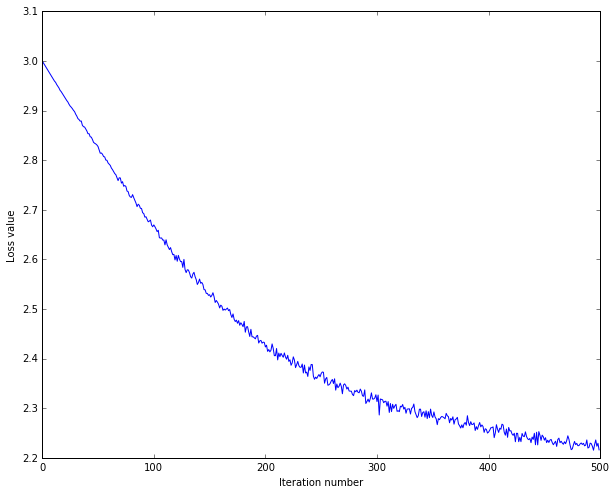

In [27]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

Как видно по графику, сходимость loss value еще не наступила. Возможно нужно больше итераций или увеличить learning rate.

Теперь посмотрим как работает predict у SVM:

In [30]:
# Write the LinearSVM.predict function 
y_train_pred = svm.predict(X_train)

In [31]:
print(classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

          0       0.48      0.30      0.37     35097
          1       0.55      0.04      0.08     20066
          2       0.41      0.01      0.02     53979
          3       0.72      0.97      0.83    243136

avg / total       0.64      0.71      0.62    352278



In [32]:
# compare result with the most common dummy classifier
print(classification_report(y_train, [3]*len(y_train)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     35097
          1       0.00      0.00      0.00     20066
          2       0.00      0.00      0.00     53979
          3       0.69      1.00      0.82    243136

avg / total       0.48      0.69      0.56    352278



/Users/nastya/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Как и ожидалось, svm работает лучше чем dummy classifier

--------

## Softmax Classifier

Так же, как и в случае SVM реализуем две версии функции потерь: с циклами и векторизованную.

In [18]:
# First implement the naive softmax loss function with nested loops.

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(4, X_train_sample.shape[0]) * 0.01 
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 1.385378
sanity check: 2.302585


Проверяем работу наивной версии:

In [10]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: softmax_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: -0.000034 analytic: -0.000034, relative error: 6.401608e-08
numerical: 0.000011 analytic: 0.000011, relative error: 1.600514e-07
numerical: 0.000042 analytic: 0.000042, relative error: 2.248464e-08
numerical: 0.000003 analytic: 0.000003, relative error: 3.905276e-06
numerical: 0.000008 analytic: 0.000008, relative error: 4.671906e-07


Также как и в случае SVM получаем ошибку порядка $10^{-7}$ - $10^{-8}$, значит все в порядке.

Сравним наивную и векторную реализации:

In [22]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 1.385390e+00 computed in 3.733446s
vectorized loss: 1.385390e+00 computed in 0.544031s
Loss difference: 0.000000
Gradient difference: 0.000000


Тут опять все хорошо, все считается правильно, ну и как ожидалось векторная версия работает в 10 раз быстрее.

Теперь проверим работу Softmax classifier:

In [36]:
sm = Softmax()
tic = time.time()
loss_hist = sm.train(X_train, y_train, learning_rate=5e-2, lambda_=0.01,
                      num_iters=500, verbose=True, batch_size=20000)

toc = time.time()
print('That took %fs' % (toc - tic))
print('Current loss is %f' % loss_hist[-1])

iteration 0 / 500: loss 1.386450, best_loss 1.386450
iteration 100 / 500: loss 1.365833, best_loss 1.365833
iteration 200 / 500: loss 1.350062, best_loss 1.350062
iteration 300 / 500: loss 1.338302, best_loss 1.338102
iteration 400 / 500: loss 1.328498, best_loss 1.327856
That took 517.329016s
Current loss is 1.322960


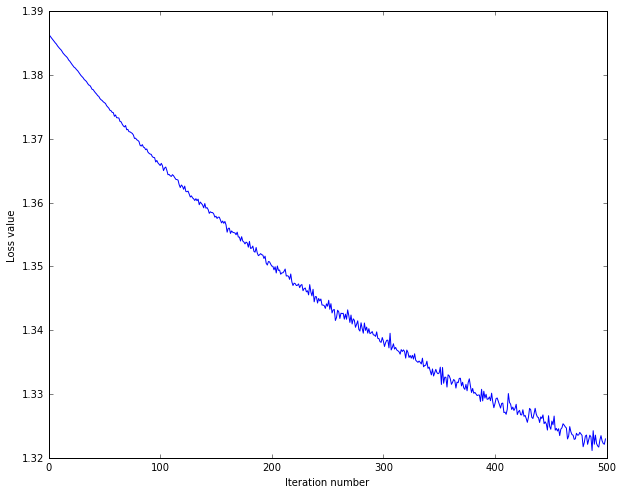

In [37]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

Тут как и в случае SVM скорее всего нужно больше итерации или большой learning rate.

Проверим работу predict:

In [39]:
# Write the Softmax  function 
y_train_pred = sm.predict(X_train)

In [41]:
print(classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

          0       0.47      0.30      0.36     35097
          1       0.42      0.05      0.09     20066
          2       0.30      0.02      0.03     53979
          3       0.72      0.97      0.83    243136

avg / total       0.62      0.70      0.62    352278



In [43]:
# compare result with the most common dummy classifier
print(classification_report(y_train, [3]*len(y_train)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     35097
          1       0.00      0.00      0.00     20066
          2       0.00      0.00      0.00     53979
          3       0.69      1.00      0.82    243136

avg / total       0.48      0.69      0.56    352278



/Users/nastya/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Тут тоже, как и ожидалось predict дает результаты лучше, чем dummy classifier.

------

### Kaggle

Как уже было упомянуто выше, для решения контеста не получится использовать SVM, поскольку там нужно минимизировать log_loss, а ответ SVM не является распределением вероятностей классов. 

Поэтому кросс-валидацию будем проводить только для Softmax. Для этого кстати пришлось написать отдельную функцию, которая возвращает распределение, а не просто ответ.

Ниже просто код для тренировки Softmax на подобранных в кросс-валидации(см еще чуть-чуть ниже) параметрах. Как видно, из-за маленького batch-size возрастает дисперсия loss-value, но зато можно добиться более низких значений log_loss, поскольку тут на самом деле берется матрица весов с наименьшим значением функции потерь за все шаги(отсюда и best_loss в debug outputе).

In [41]:
sm = Softmax()
tic = time.time()
loss_hist = sm.train(X_train, y_train, learning_rate=3, lambda_=1e-7,
                      num_iters=7000, verbose=True, batch_size=500)

toc = time.time()
print('That took %fs' % (toc - tic))
print('Current loss is %f' % loss_hist[-1])

iteration 0 / 7000: loss 1.386194, best_loss 1.386194
iteration 100 / 7000: loss 0.985144, best_loss 0.939528
iteration 200 / 7000: loss 0.910265, best_loss 0.871015
iteration 300 / 7000: loss 0.869388, best_loss 0.832539
iteration 400 / 7000: loss 0.884260, best_loss 0.804443
iteration 500 / 7000: loss 0.822382, best_loss 0.735541
iteration 600 / 7000: loss 0.823000, best_loss 0.735541
iteration 700 / 7000: loss 0.825830, best_loss 0.726971
iteration 800 / 7000: loss 0.783347, best_loss 0.717778
iteration 900 / 7000: loss 0.811269, best_loss 0.717778
iteration 1000 / 7000: loss 0.806982, best_loss 0.717778
iteration 1100 / 7000: loss 0.816095, best_loss 0.690400
iteration 1200 / 7000: loss 0.763305, best_loss 0.666553
iteration 1300 / 7000: loss 0.773341, best_loss 0.666553
iteration 1400 / 7000: loss 0.736400, best_loss 0.666553
iteration 1500 / 7000: loss 0.778578, best_loss 0.666553
iteration 1600 / 7000: loss 0.810065, best_loss 0.666553
iteration 1700 / 7000: loss 0.746719, best_

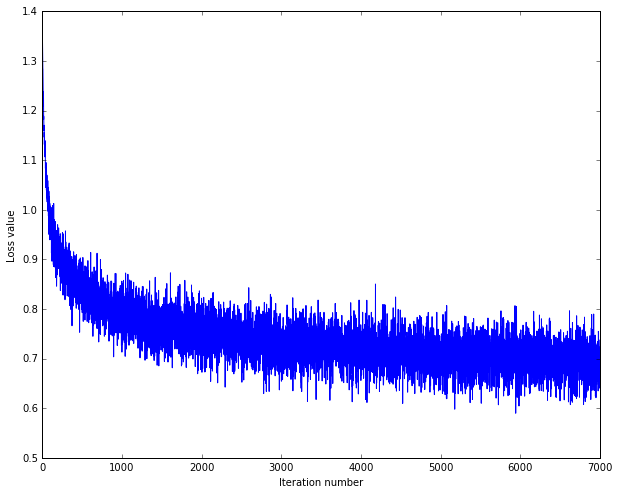

In [43]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [44]:
probs = sm.predict_probabilities(X_test)

In [45]:
output_to_csv(probs,test_data.index.values, 'output.csv')

## Cross validation

Будем подбирать learning_rate, коэффициент регуляризации, количество итераций и batch_size, минимизируя  log_loss.

In [8]:
# prepare parameters
learning_rates = [1]
lambdas = [0]
num_iters = []
batch_sizes = []
for power in range(1,10):
    lambdas.append(math.pow(10, -power))
    if power < 5:
        ten_power = math.pow(10, -power)
        learning_rates.append(ten_power)
        learning_rates.append(5*ten_power)
    if 2 < power < 6:
        batch_sizes.append(int(math.pow(10,power)))
    if power > 1:
        num_iters.append(power*1000)
format_str = 'learning_rates: {}\nlambdas: {}\nnum_iters: {}\nbatch_sizes: {}\n'
print(format_str.format(learning_rates, lambdas, num_iters, batch_sizes))

learning_rates: [1, 0.1, 0.5, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005]
lambdas: [0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09]
num_iters: [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
batch_sizes: [1000, 10000, 100000]



Ниже приведен сам процесс кросс-валидации. Результаты можно посмотреть в cross_validation_report.txt.

По ним видно, что лучшие результаты дает алгоритм с наибольшим learning_rate = 1, причем результат улучшается с увеличением количества итераций. Также лучше всего оказалось убрать регуляризацию или сделать ее порядка $10^{-7}$, тоже самое с batch_size: его увеличение не повлияло на результат.Лучше было его уменьшить для ускорения.

Наоборот, после кросс-валидации стало понятно, что лучше всего будет увеличить еще немного learning_rate, уменьшить batch_size и немного поиграть c размером векторов и стоп-словами.

Итого, лучшие результаты дал алгоритм с параметрами: 

learning_rate=3, lambda_=1e-7, num_iters=7000, batch_size=500 stop_words=english max_features=4000

Кстати, видимо поскольку модель линейная, результат на Kaggle почти не отличался от полученного в кросс-валидации.

In [ ]:
# cross validation process
for iters in num_iters:
    for lambda_ in lambdas:
        for rate in learning_rates:
            X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train.T, y_train, test_size=0.33)
            X_train_s = X_train_s.T
            X_test_s = X_test_s.T
            sm = Softmax()
            tic = time.time()
            loss_hist = sm.train(X_train_s, y_train_s, learning_rate=rate, lambda_=lambda_,
                                 num_iters=iters, batch_size=500)
            toc = time.time()
            pred_probs = sm.predict_probabilities(X_test_s)
            score = log_loss(y_test_s, pred_probs)
            print('Training took %fs' % (toc - tic))
            print('Parameters: num_iters: {},batch_size: {},lambda: {}, learning_rate: {}'.format(iters, 1000,
                                                                                                  lambda_, rate))
            print('Current log_loss is %f' % score)